# **MUSIC GENERATION PROJECT: GIULIA SARESINI, VANESSA MAEDER**

## **Purpose of the Work**

This work serves as an initial approach to music generation. The focus has been on the **MAESTRO dataset**, which contains piano music. Specifically, the goal is to train a conditional GAN (cGAN) capable of generating music. 

Link to download the dataset: https://magenta.tensorflow.org/datasets/maestro#v300

File to Download: maestro-v3.0.0-midi.zip

# **NECESSARY LIBRARY**

In [2]:
import os
import pandas as pd
import pretty_midi
import matplotlib.pyplot as plt
import numpy as np
import csv
from music21 import converter
import tempfile
import ast
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import random
import gensim.downloader as api
import spacy
import mido

# **DATA SELECTION**

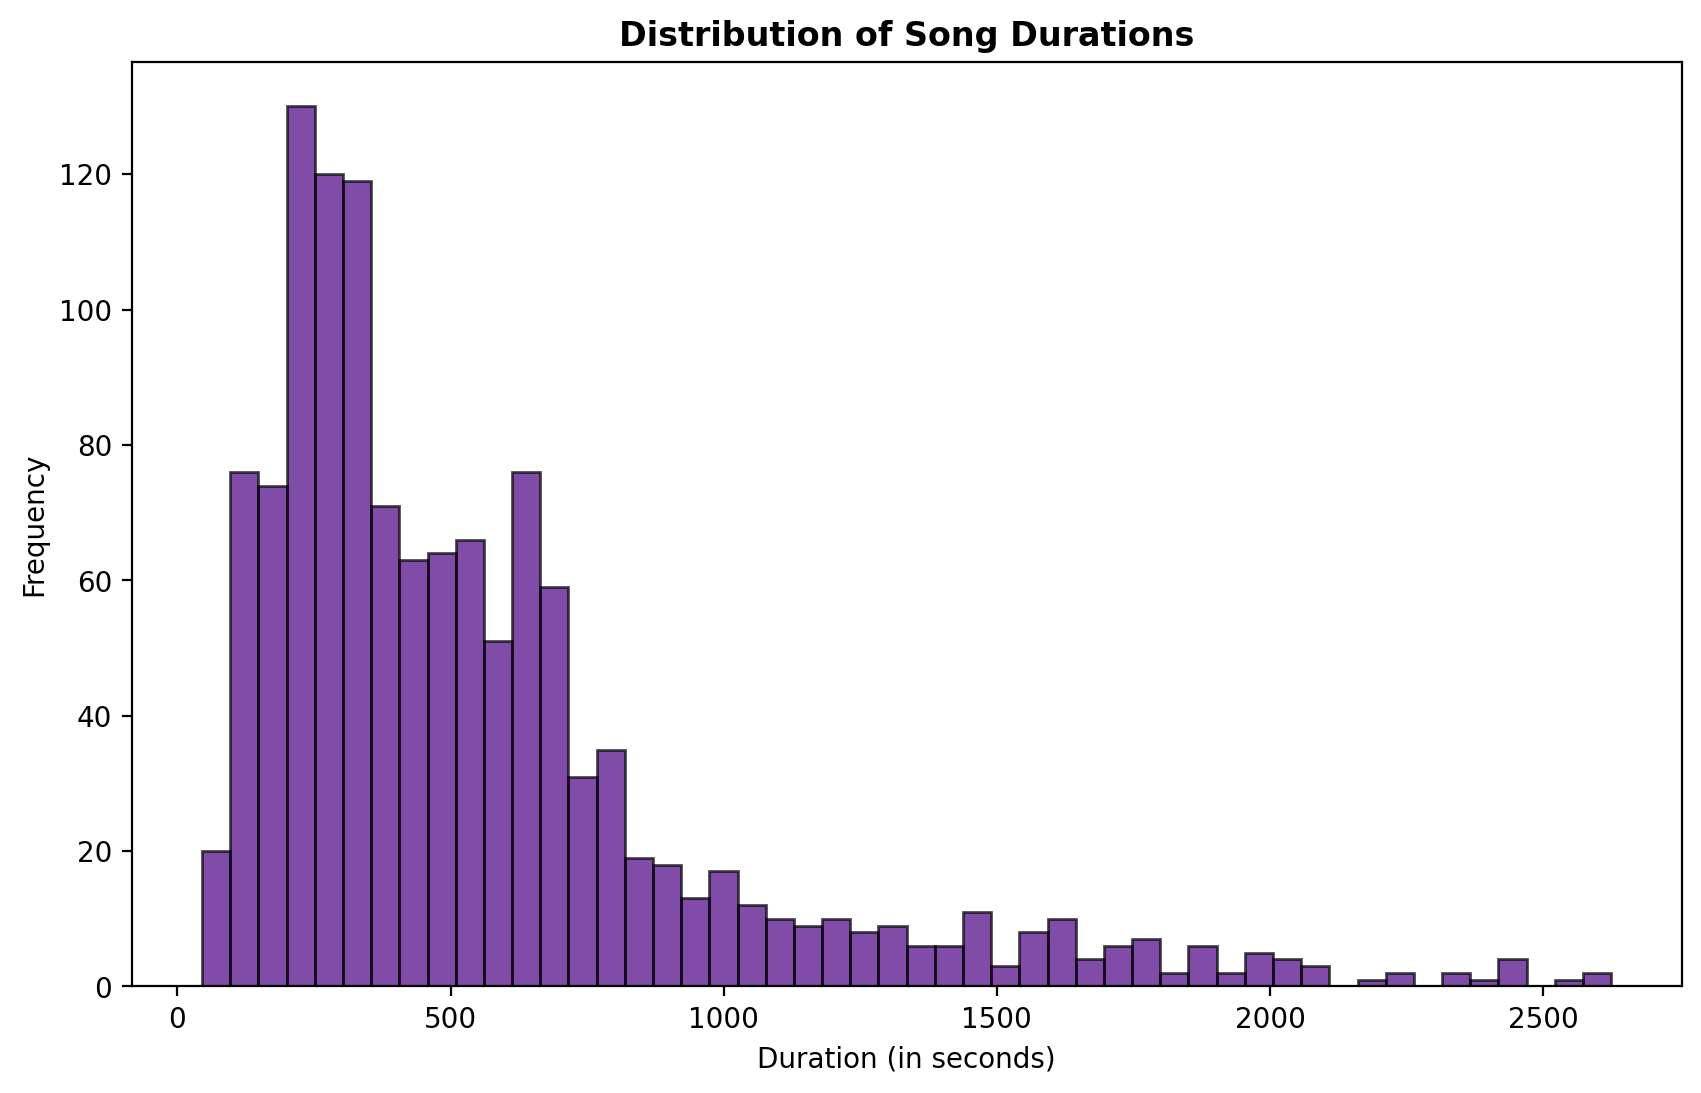

In [3]:
# Load the metadata
metadata = pd.read_csv('/Users/giuliasaresini/Documents/tesi_vs/Bio/Maestro/maestro-v3.0.0/maestro-v3.0.0.csv')  # Make sure to enter the correct path
metadata.drop_duplicates(inplace=True)
metadata.dropna(inplace=True)

# List to store total durations
durations = []

# Process MIDI files
for index, row in metadata.iterrows():
    midi_path = os.path.join('/Users/giuliasaresini/Documents/tesi_vs/Bio/Maestro/maestro-v3.0.0', row['midi_filename'])  # Enter the correct path

    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)

        # Extract notes
        for instrument in midi_data.instruments:
            notes = sorted(instrument.notes, key=lambda note: note.start)

            if len(notes) > 0:
                # The song duration is the `end` of the last note
                song_duration = notes[-1].end
                durations.append(song_duration)
    except Exception as e:
        print(f"Error in file {midi_path}: {e}")

# Create a plot of the duration distribution
plt.figure(figsize=(10, 6))
plt.hist(durations, bins=50, color='#4B0082', edgecolor='black', alpha=0.7)  # Dark purple
plt.title('Distribution of Song Durations', fontweight='bold')  # Bold title
plt.xlabel('Duration (in seconds)')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

Observing the data distribution and having decided to train the neural network using entire compositions to allow it to learn patterns within the pieces, it was decided to retain only the compositions with a duration between 180 and 300 seconds.

# **MAESTRO DATASET - DATA EXTRACTION**

In [3]:
# Function to fix the key notation
def fix_key_notation(key_name):
    if '- minor' in key_name:
        key_name = key_name.replace('- minor', ' minor')
    if '- major' in key_name:
        key_name = key_name.replace('- major', ' major')
    return key_name

# Function to estimate the key
def estimate_key(midi_data):
    try:
        # Create a temporary file to analyze the MIDI with music21
        with tempfile.NamedTemporaryFile(suffix='.mid', delete=False) as temp_file:
            temp_file_name = temp_file.name
            midi_data.write(temp_file_name)

            # Analyze the key using music21
            score = converter.parse(temp_file_name)
            music_analysis = score.analyze('key')
            os.remove(temp_file_name)

            # Mapping of major and minor keys
            key_mapping = {
                'C major': 1, 'C# major': 1, 'D major': 1, 'D# major': 1, 'E major': 1, 'F major': 1,
                'F# major': 1, 'G major': 1, 'G# major': 1, 'A major': 1, 'A# major': 1, 'B major': 1,
                'c minor': 0, 'c# minor': 0, 'd minor': 0, 'd# minor': 0, 'e minor': 0, 'f minor': 0,
                'f# minor': 0, 'g minor': 0, 'g# minor': 0, 'a minor': 0, 'a# minor': 0, 'b minor': 0
            }

            # Fix the key notation
            key_name = fix_key_notation(str(music_analysis).strip())

            # Return 1 for major and 0 for minor
            return key_mapping.get(key_name, -1)  # -1 if the key is not recognized
    except Exception as e:
        print(f"Error during key analysis: {e}")
        return -1  # Return -1 in case of an error

# Load the metadata
metadata = pd.read_csv('Maestro/maestro-v3.0.0/maestro-v3.0.0.csv')
metadata.drop_duplicates(inplace=True)
metadata.dropna(inplace=True)

# Path to processed dataset
csv_file = 'dataset_cGAN.csv'

# Parameters
fieldnames = ['pitches', 'starts', 'ends', 'velocity', 'key']

# Open the CSV file to write the data
with open(csv_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    # Process MIDI files
    for index, row in metadata.iterrows():
        midi_path = os.path.join('Maestro/maestro-v3.0.0', row['midi_filename'])

        try:
            midi_data = pretty_midi.PrettyMIDI(midi_path)

            # Get the total duration of the MIDI (use end time of the last note or max end time)
            total_duration = max([note.end for instrument in midi_data.instruments for note in instrument.notes])

            # Only consider songs with duration between 180 and 300 seconds
            if total_duration < 180 or total_duration > 300:
                continue

            # Extract the key as a number
            key_numeric = estimate_key(midi_data)

            # Process each instrument
            for instrument in midi_data.instruments:
                notes = sorted(instrument.notes, key=lambda note: note.start)

                # Now we collect all the notes for the entire song without windowing
                pitches = [note.pitch for note in notes]
                starts = [note.start for note in notes]
                ends = [note.end for note in notes]
                velocity = [note.velocity for note in notes]

                # Write to the CSV
                writer.writerow({
                    'pitches': pitches,
                    'starts': starts,
                    'ends': ends,
                    'velocity': velocity,
                    'key': key_numeric
                })

        except Exception as e:
            print(f"Error in file {midi_path}: {e}")

print("Dataset created and saved.")


Dataset created and saved.


The function for data extraction filters compositions with a duration between **180 and 300 seconds**.  
For each piece that meets this criterion, it extracts the following information:

- **`pitches`**: Pitch values of the notes.
- **`starts`**: Start times of the notes.
- **`ends`**: End times of the notes.
- **`velocity`**: Velocity values of the notes.
- **`key`**: A binary value indicating whether the composition is written in a **major key** or a **minor key**.

# **DATA EXPLORATION**

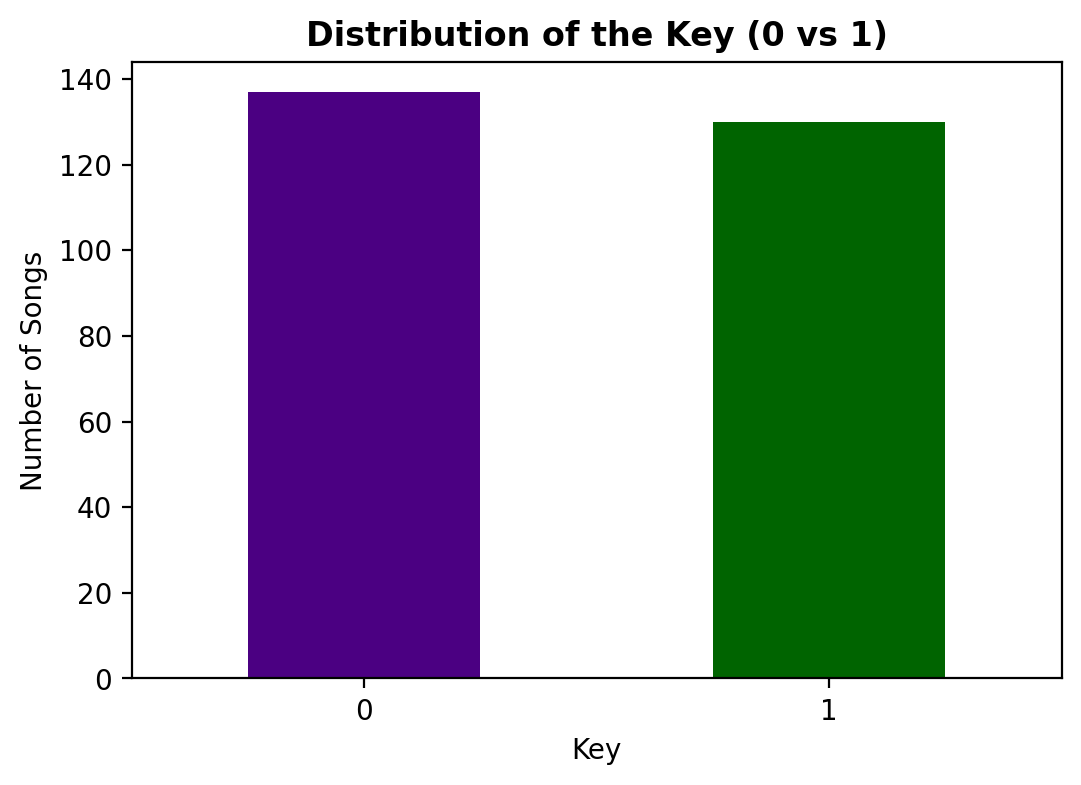

In [9]:
# Path to processed dataset
dataset_path = 'dataset_cGAN.csv'

# Load the dataset
data = pd.read_csv(dataset_path)

# Count the different keys in the dataset (0's and 1's)
key_counts = data['key'].value_counts()

# Plot the counts for the 'key' column
plt.figure(figsize=(6, 4))
key_counts.plot(kind='bar', color=['#4B0082','darkgreen'])  
plt.title('Distribution of the Key (0 vs 1)', fontweight='bold')  
plt.xlabel('Key')
plt.ylabel('Number of Songs')
plt.xticks(rotation=0)
plt.show()


The Distribution of the class 'key' is balanced in the dataset

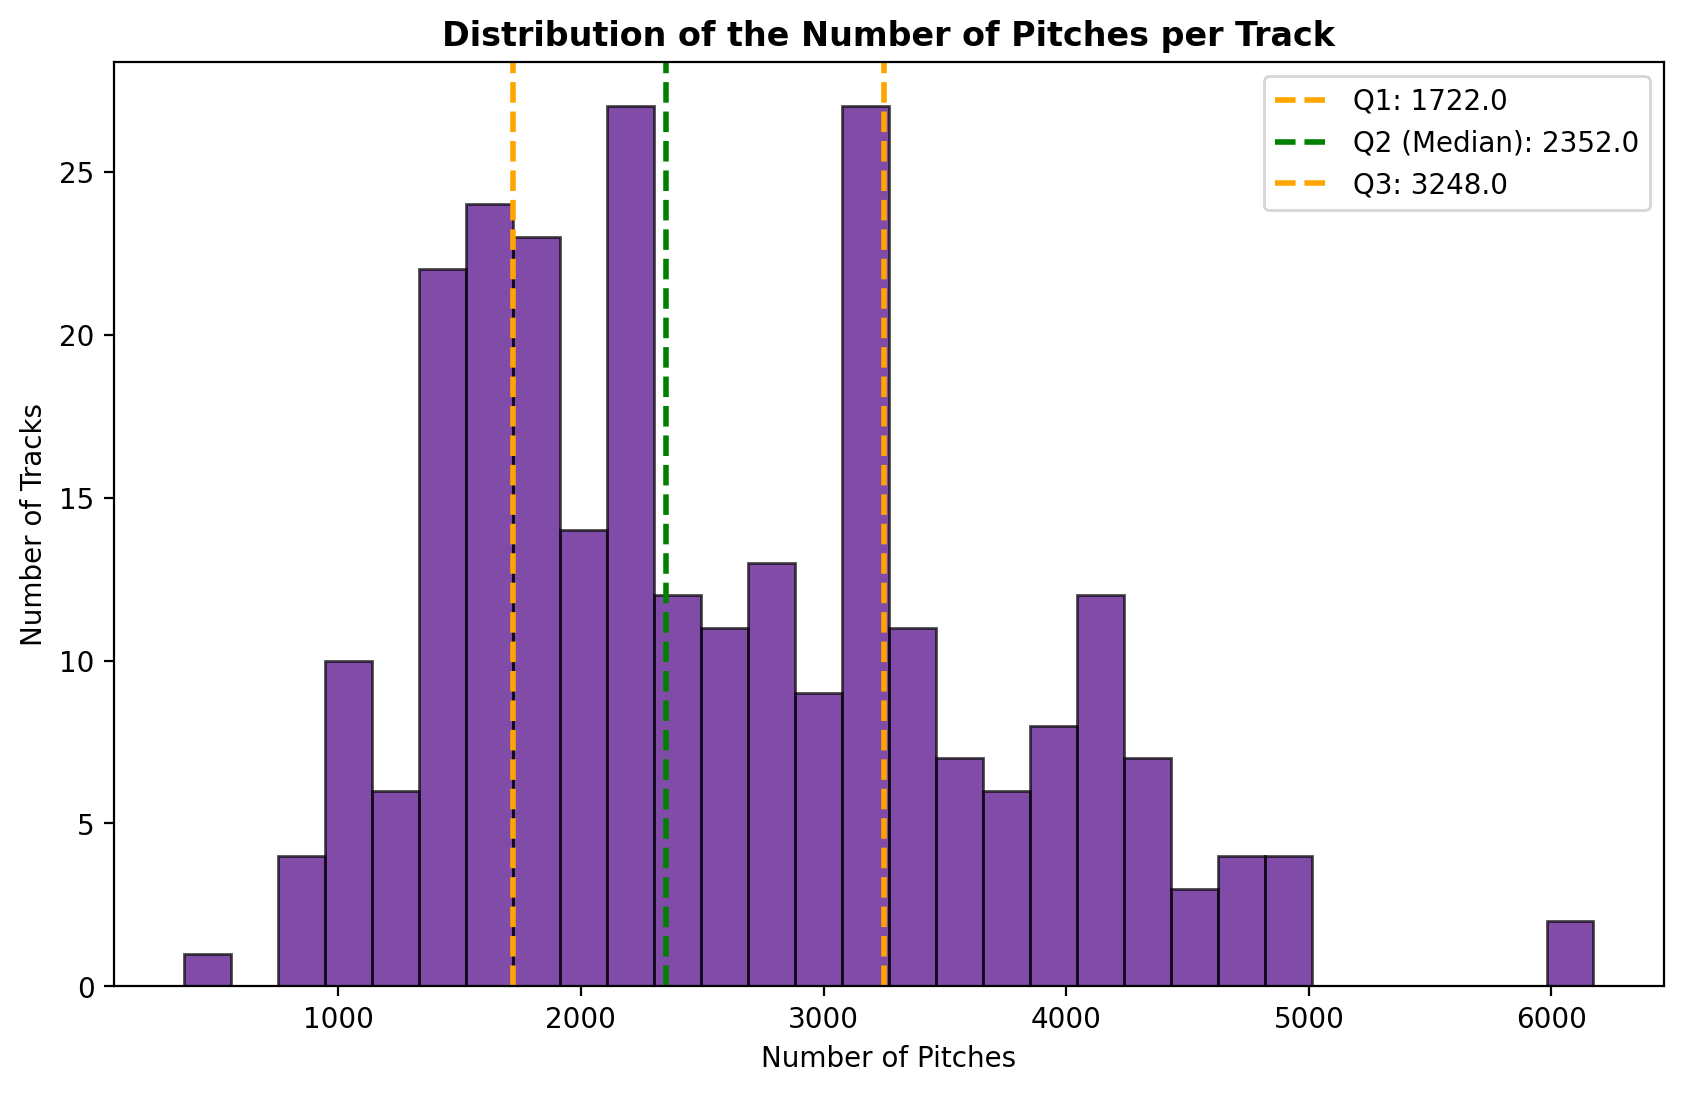

In [11]:
# Load the cGAN dataset
dataset_path = 'dataset_cGAN.csv'
df = pd.read_csv(dataset_path)

# Make sure the 'pitches' column is properly formatted as a list of numbers
# 'ast.literal_eval' converts a string representing a list to a list in Python
df['pitches'] = df['pitches'].apply(ast.literal_eval)

# Calculate the length of each list of pitches
df['num_pitches'] = df['pitches'].apply(len)

# Calculate the quartiles
Q1 = df['num_pitches'].quantile(0.25)
Q2 = df['num_pitches'].quantile(0.50)  # Median
Q3 = df['num_pitches'].quantile(0.75)
IQR = Q3 - Q1  # Interquartile range

# Create the histogram
plt.figure(figsize=(10, 6))

# Histogram with custom bin color
plt.hist(df['num_pitches'], bins=30, color='#4B0082', edgecolor='black', alpha=0.7)

# Quartile lines with the same color for Q1 and Q3
plt.axvline(Q1, color='orange', linestyle='dashed', linewidth=2, label=f'Q1: {Q1}')
plt.axvline(Q2, color='green', linestyle='dashed', linewidth=2, label=f'Q2 (Median): {Q2}')
plt.axvline(Q3, color='orange', linestyle='dashed', linewidth=2, label=f'Q3: {Q3}')

# Title in bold
plt.title('Distribution of the Number of Pitches per Track', fontweight='bold')

# Axes lables
plt.xlabel('Number of Pitches')
plt.ylabel('Number of Tracks')

# Remove the grid
plt.grid(False)

# Add the legend
plt.legend()

# Show the graph
plt.show()

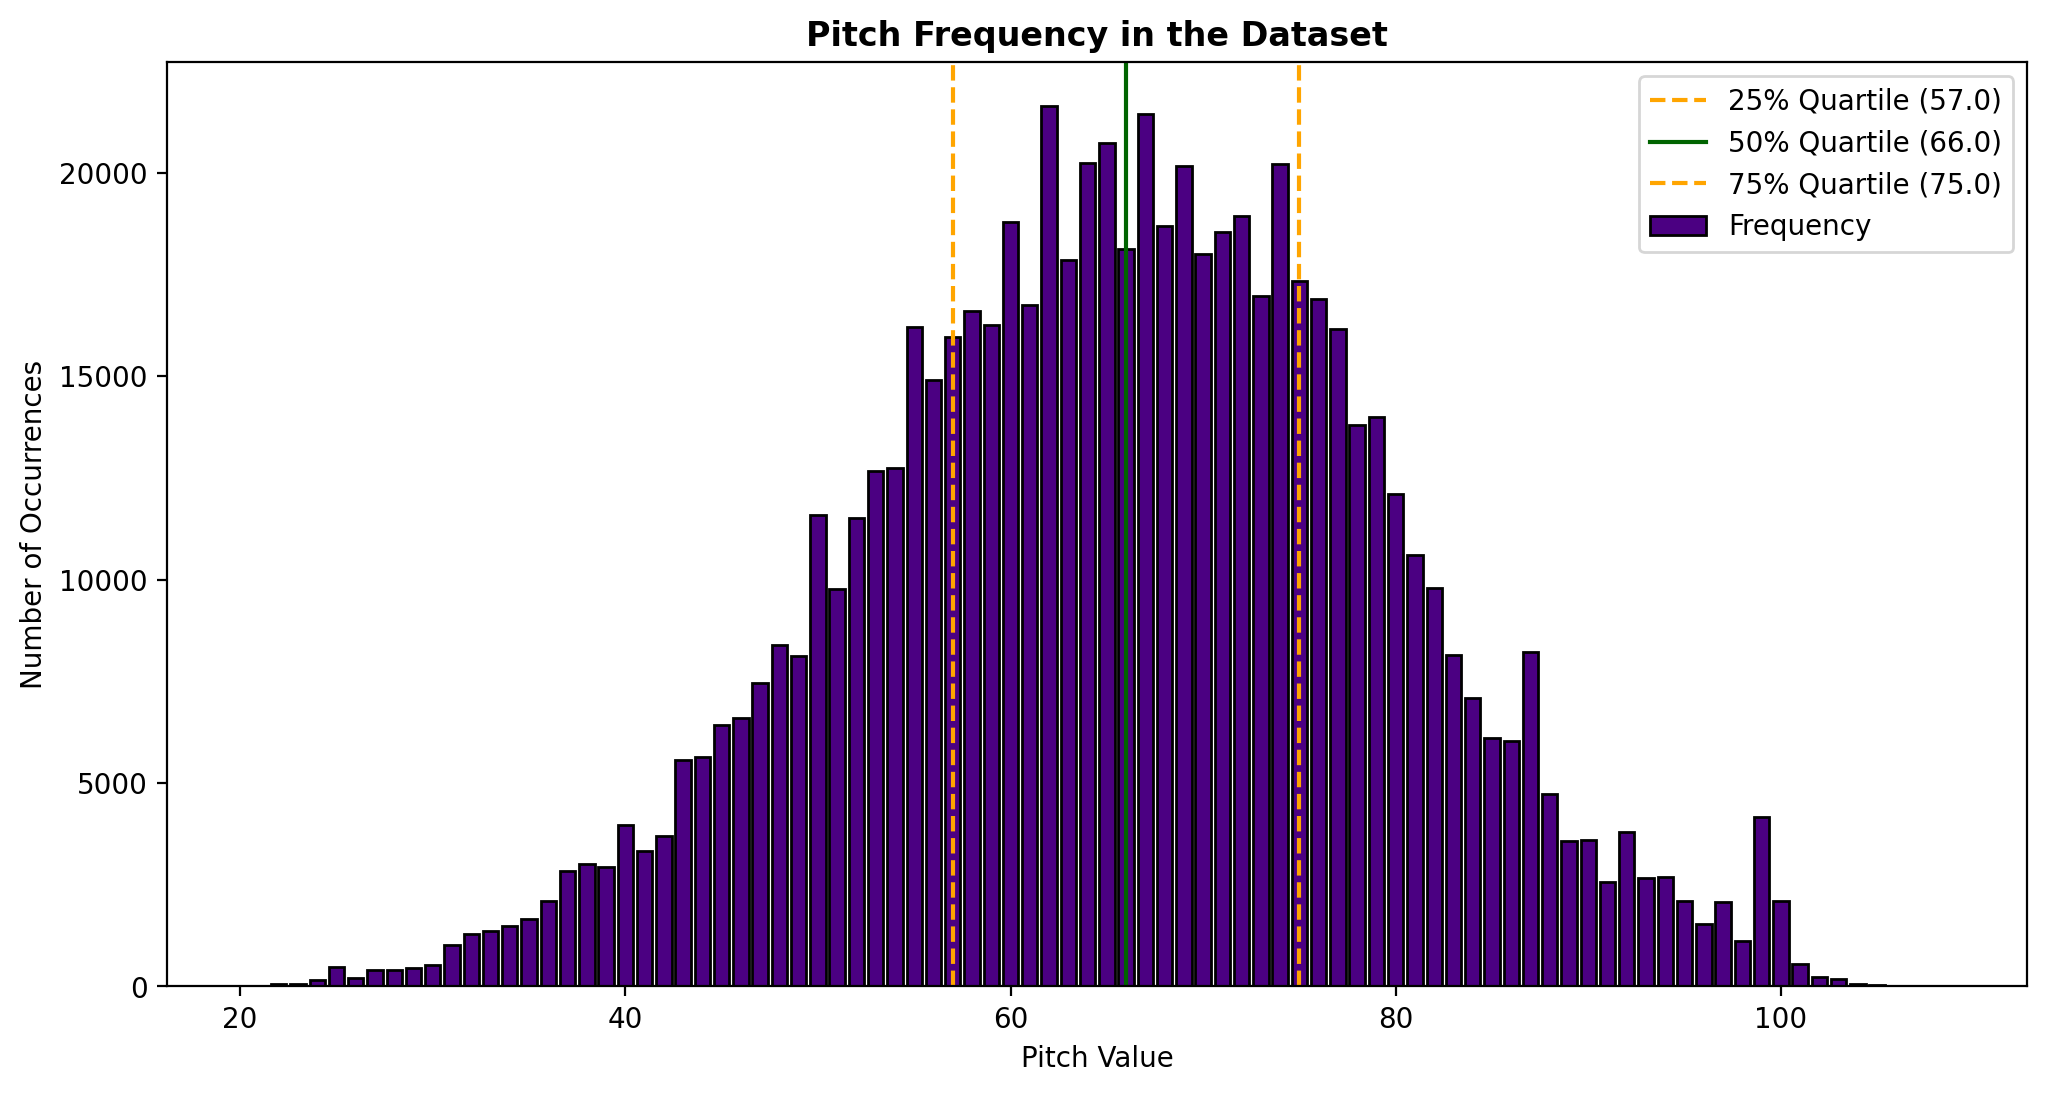

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import ast  # To convert the list of strings into a list of numbers

# Load the dataset
dataset_path = 'dataset_cGAN.csv'
df = pd.read_csv(dataset_path)

# Make sure the 'pitches' column is correctly formatted as a list of numbers
df['pitches'] = df['pitches'].apply(ast.literal_eval)

# Combine all pitches into a single array to calculate the frequency
all_pitches = [pitch for sublist in df['pitches'] for pitch in sublist]

# Calculate the frequency of each pitch
pitch_counts = pd.Series(all_pitches).value_counts().sort_index()

# Calculate the quartiles
q1 = pd.Series(all_pitches).quantile(0.25)
q2 = pd.Series(all_pitches).quantile(0.50)  # Median
q3 = pd.Series(all_pitches).quantile(0.75)

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(pitch_counts.index, pitch_counts.values, color='#4B0082', edgecolor='black', label='Frequency')

# Add the quartiles
plt.axvline(x=q1, color='orange', linestyle='--', label=f'25% Quartile ({q1})')
plt.axvline(x=q2, color='darkgreen', linestyle='-', label=f'50% Quartile ({q2})')
plt.axvline(x=q3, color='orange', linestyle='--', label=f'75% Quartile ({q3})')

# Add title and labels
plt.title('Pitch Frequency in the Dataset', fontweight='bold')
plt.xlabel('Pitch Value')
plt.ylabel('Number of Occurrences')
plt.legend()
plt.grid(False)

# Show the chart
plt.show()


# **PREPROCESSING**

## **DATA PADDING**

In [47]:
# Load the dataset
dataset_path = 'dataset_cGAN.csv'
df = pd.read_csv(dataset_path)

# Calculate the length of each 'pitches' list
df['num_pitches'] = df['pitches'].apply(len)

# Calculate the quartiles and IQR
Q1 = df['num_pitches'].quantile(0.25)
Q3 = df['num_pitches'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df_cleaned = df[(df['num_pitches'] >= lower_bound) & (df['num_pitches'] <= upper_bound)]

# Function to add padding
def add_padding(arr, N):
    # Check if arr is a string, try converting it to list
    if isinstance(arr, str):
        arr = ast.literal_eval(arr)  # Use literal_eval to convert it to a list
    # Add padding until you reach N items
    while len(arr) < N:
        arr.append(0)  # Add a zero to the list until you reach the desired length.
    return arr

# Calculate the maximum length of 'pitches' (the padding_N)
df_cleaned['num_pitches'] = df_cleaned['pitches'].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else len(x))
padding_N = max(df_cleaned['num_pitches'])  # The maximum length of the pitch list
print(f"Padding N: {padding_N}")

# Apply padding to all relevant columns
df_cleaned['velocity'] = df_cleaned.apply(lambda row: add_padding(row['velocity'], padding_N), axis=1)
df_cleaned['starts'] = df_cleaned.apply(lambda row: add_padding(row['starts'], padding_N), axis=1)
df_cleaned['ends'] = df_cleaned.apply(lambda row: add_padding(row['ends'], padding_N), axis=1)
df_cleaned['pitches'] = df_cleaned.apply(lambda row: add_padding(row['pitches'], padding_N), axis=1)

print(len(df_cleaned['pitches'][0]))
print(len(df_cleaned['velocity'][0]))
print(len(df_cleaned['starts'][0]))
print(len(df_cleaned['ends'][0]))


# Save the modified dataset with padded columns
output_path = 'dataset_padded_cGAN.csv'
df_cleaned.to_csv(output_path, index=False)

# View modified dataset (optional)
print(df_cleaned.head())

/var/folders/tj/7m7f0dn51772hz65_qmb34940000gn/T/ipykernel_24043/2082425396.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['num_pitches'] = df_cleaned['pitches'].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else len(x))


Padding N: 5011


/var/folders/tj/7m7f0dn51772hz65_qmb34940000gn/T/ipykernel_24043/2082425396.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['velocity'] = df_cleaned.apply(lambda row: add_padding(row['velocity'], padding_N), axis=1)
/var/folders/tj/7m7f0dn51772hz65_qmb34940000gn/T/ipykernel_24043/2082425396.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['starts'] = df_cleaned.apply(lambda row: add_padding(row['starts'], padding_N), axis=1)
/var/folders/tj/7m7f0dn51772hz65_qmb34940000gn/T/ipy

5011
5011
5011
5011
                                             pitches  \
0  [47, 50, 54, 83, 59, 81, 79, 78, 76, 74, 76, 7...   
1  [65, 67, 69, 70, 68, 66, 65, 67, 69, 70, 68, 6...   
2  [61, 70, 69, 67, 77, 73, 70, 69, 67, 61, 67, 7...   
3  [80, 76, 78, 74, 76, 72, 74, 70, 68, 72, 84, 8...   
4  [82, 87, 84, 77, 72, 80, 82, 87, 84, 77, 72, 8...   

                                              starts  \
0  [0.9544270833333333, 0.9674479166666666, 1.016...   
1  [1.0, 1.0768229166666665, 1.1549479166666665, ...   
2  [1.0143229166666665, 1.4361979166666665, 1.457...   
3  [1.01171875, 1.0169270833333333, 2.38541666666...   
4  [0.96484375, 1.28125, 1.4739583333333333, 1.63...   

                                                ends  \
0  [1.23046875, 1.2526041666666665, 1.29296875, 1...   
1  [1.0638020833333333, 1.1223958333333333, 1.207...   
2  [1.2786458333333333, 1.4830729166666665, 1.539...   
3  [1.6458333333333333, 1.9583333333333333, 2.552...   
4  [1.28515625, 1.41796875

## **DATA NORMALIZATION**

In [67]:
# Load the dataset
dataset_path = 'dataset_padded_cGAN.csv'
df = pd.read_csv(dataset_path)

# Apply ast.literal_eval() to all rows of the specified columns
columns_to_convert = ['pitches', 'velocity', 'starts', 'ends']

for col in columns_to_convert:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Function to normalize columns
def normalize_column(column, divisor):
    return np.array(column) / divisor

# Normalize the columns 'starts', 'ends', 'velocity' and 'pitches'
df['starts_normalized'] = df['starts'].apply(lambda lst: [x / 300.0 for x in lst])  # use eval to convert it to list if it is a string
df['ends_normalized'] = df['ends'].apply(lambda lst: [x / 300.0 for x in lst])  # same thing for ends
df['velocities_normalized'] = df['velocity'].apply(lambda lst: [x / 127.0 for x in lst])  # normalization for velocity
df['pitches_normalized'] = df['pitches'].apply(lambda lst: [x / 127.0 for x in lst])  # normalization for velocity


print(len(df['pitches_normalized'][0]))
print(len(df['velocities_normalized'][0]))
print(len(df['starts_normalized'][0]))
print(len(df['ends_normalized'][0]))

# Create new dataset with normalized columns and &#39;key&#39;
df_normalized = df[['key', 'pitches_normalized', 'velocities_normalized', 'starts_normalized', 'ends_normalized']]

# Save the normalized dataset to a new CSV file
output_path = 'dataset_normalized_cGAN.csv'
df_normalized.to_csv(output_path, index=False)

# Visualize the normalized dataset (optional)
print(df_normalized.head())

5011
5011
5011
5011
   key                                 pitches_normalized  \
0    0  [0.3700787401574803, 0.3937007874015748, 0.425...   
1    1  [0.5118110236220472, 0.5275590551181102, 0.543...   
2    1  [0.48031496062992124, 0.5511811023622047, 0.54...   
3    1  [0.6299212598425197, 0.5984251968503937, 0.614...   
4    1  [0.6456692913385826, 0.6850393700787402, 0.661...   

                               velocities_normalized  \
0  [0.3543307086614173, 0.4566929133858268, 0.511...   
1  [0.3543307086614173, 0.3937007874015748, 0.354...   
2  [0.2677165354330709, 0.33858267716535434, 0.26...   
3  [0.3700787401574803, 0.33858267716535434, 0.34...   
4  [0.30708661417322836, 0.29133858267716534, 0.2...   

                                   starts_normalized  \
0  [0.003181423611111111, 0.0032248263888888886, ...   
1  [0.0033333333333333335, 0.0035894097222222217,...   
2  [0.0033810763888888883, 0.004787326388888889, ...   
3  [0.003372395833333333, 0.0033897569444444444, ...

# **CGAN TRAINING**

In [3]:
import pandas as pd
import tensorflow as tf
import random
from sklearn.preprocessing import OneHotEncoder
import numpy as np 
import ast

random.seed(49)

# Load the dataset
dataset_path = 'dataset_normalized_cGAN.csv'
df = pd.read_csv(dataset_path)

# Apply ast.literal_eval() to all rows of the specified columns
columns_to_convert = ['pitches_normalized', 'velocities_normalized']

for col in columns_to_convert:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# One-hot encode the 'key' column
key_encoder = OneHotEncoder(sparse_output=False)
df['key_encoded'] = list(key_encoder.fit_transform(df[['key']]))

# Create a copy of the DataFrame for modification
df_copy = df.copy()

# Drop the original 'key' column and rename 'key_encoded' to 'key'
df_copy.drop(['key'], axis=1, inplace=True)
df_copy.rename(columns={'key_encoded': 'key'}, inplace=True)

# Prepare the training input by stacking the columns into a single array
train_input = np.hstack([
    np.stack(df_copy['pitches_normalized'].values),  # Adjust shape to (n, 1)
    np.stack(df_copy['velocities_normalized'].values)  # Adjust shape to (n, 1)
])

# Concatenate the one-hot encoded 'key' as conditions
train_conditions = np.hstack([np.stack(df_copy['key'].values)])

# Determine the pitch length (assuming all pitches are of the same length)
pitch_length = len(df_copy['pitches_normalized'].iloc[0])

# Set model parameters
pitch_dim = pitch_length
noise_dim = pitch_length

# Print out some details for verification
print(f"pitch_dim: {pitch_dim}")
print(f"noise_dim: {noise_dim}")
print(f"train_input shape: {train_input.shape}")
print(f"train_conditions shape: {train_conditions.shape}")


# Add Noise
def add_noise(inputs, stddev=0.1):
    return inputs + tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=stddev)

# Repetition Penalty
def repetition_penalty(generated_pitches, generated_durations, min_duration=0.1):
    """ Penalizes drastic changes in pitch and very short durations between consecutive notes. """
    pitch_diff = tf.abs(generated_pitches[:, 1:] - generated_pitches[:, :-1])
    repetition_cost = tf.reduce_mean(pitch_diff)
    
    duration_diff = tf.abs(generated_durations[:, 1:] - generated_durations[:, :-1])
    duration_cost = tf.reduce_mean(tf.cast(duration_diff < min_duration, tf.float32))  # Penalizes when the difference is too small
    
    total_cost = repetition_cost + duration_cost
    return total_cost

# Pitch Range Penalty
def pitch_range_penalty(generated_pitches):
    min_pitch = tf.reduce_min(generated_pitches)
    max_pitch = tf.reduce_max(generated_pitches)
    range_penalty = tf.abs(max_pitch - min_pitch)  # Penalizes when the range is too small
    return range_penalty


# Minibatch Discrimination Layer
class MinibatchDiscrimination(tf.keras.layers.Layer):
    def __init__(self, num_kernels, dim_per_kernel, **kwargs):
        super(MinibatchDiscrimination, self).__init__(**kwargs)
        self.num_kernels = num_kernels
        self.dim_per_kernel = dim_per_kernel

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.num_kernels * self.dim_per_kernel),
            initializer="random_normal", trainable=True)

    def call(self, inputs):
        M = tf.matmul(inputs, self.kernel)
        M = tf.reshape(M, (-1, self.num_kernels, self.dim_per_kernel))
        M_diff = tf.expand_dims(M, 0) - tf.expand_dims(M, 1)
        abs_diff = tf.reduce_sum(tf.abs(M_diff), axis=3)
        minibatch_features = tf.reduce_sum(tf.exp(-abs_diff), axis=1)
        return tf.concat([inputs, minibatch_features], axis=1)

# Generator
def build_generator():
    noise_input = tf.keras.Input(shape=(noise_dim,))
    condition_input = tf.keras.Input(shape=(train_conditions.shape[1],))
    
    x = tf.keras.layers.Concatenate()([noise_input, condition_input])
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Reshape((1, 512))(x)
    x = tf.keras.layers.LSTM(512, return_sequences=True)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.LSTM(256)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Outputs for pitch, velocity, and start time
    pitch_output = tf.keras.layers.Dense(pitch_dim, activation='sigmoid', name='pitch_output')(x)
    velocities_output = tf.keras.layers.Dense(pitch_dim, activation='sigmoid', name='velocities_output')(x)

    return tf.keras.Model(inputs=[noise_input, condition_input], outputs=[pitch_output, velocities_output])

# Discriminator
def build_discriminator():
    disc_input = tf.keras.Input(shape=(pitch_dim * 2,)) 
    condition_input = tf.keras.Input(shape=(train_conditions.shape[1],))

    x = tf.keras.layers.Concatenate()([disc_input, condition_input])
    x = MinibatchDiscrimination(num_kernels=10, dim_per_kernel=5)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    disc_output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs=[disc_input, condition_input], outputs=disc_output)

generator = build_generator()
discriminator = build_discriminator()

# Optimizers
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0002,
    decay_steps=10000,
    decay_rate=0.96)
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Wasserstein loss function
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

# Gradient Penalty Function for WGAN-GP
def gradient_penalty(real_samples, fake_samples, conditions):
    batch_size = real_samples.shape[0]
    alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0)
    interpolated = alpha * real_samples + (1 - alpha) * fake_samples
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        validity_interpolated = discriminator([interpolated, conditions], training=True)  # Passes conditions
    grads = gp_tape.gradient(validity_interpolated, [interpolated])[0]
    grad_l2 = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
    gradient_penalty = tf.reduce_mean((grad_l2 - 1.0) ** 2)
    return gradient_penalty

# Diversity penalty between consecutive pitches
def diversity_penalty(generated_pitches):
    diff = tf.abs(generated_pitches[:, 1:] - generated_pitches[:, :-1])
    return tf.reduce_mean(diff)  # Mean difference between consecutive pitches


#@tf.function
def train_step(real_data, real_conditions):
    noise = tf.random.normal([real_data.shape[0], noise_dim])

    # Conditional generation
    generated_pitches, generated_velocities = generator([noise, real_conditions], training=True)
    fake_discriminator_input = tf.concat([generated_pitches, generated_velocities], axis=1)

    with tf.GradientTape() as disc_tape:
        real_discriminator_input = tf.concat([real_data], axis=1)
        real_validity = discriminator([real_discriminator_input, real_conditions], training=True)
        fake_validity = discriminator([fake_discriminator_input, real_conditions], training=True)

        # Compute loss
        disc_loss = wasserstein_loss(real_validity, fake_validity)
        gp_loss = gradient_penalty(real_discriminator_input, fake_discriminator_input, real_conditions)
        disc_loss += gp_loss

    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    with tf.GradientTape() as gen_tape:
        # Conditional generation
        generated_pitches, generated_velocities = generator([noise, real_conditions], training=True)
        fake_discriminator_input = tf.concat([generated_pitches, generated_velocities], axis=1)
        
        # Discriminator output for generated data
        fake_output = discriminator([fake_discriminator_input, real_conditions], training=False)
        
        # Compute Wasserstein loss (adversarial)
        gen_loss = wasserstein_loss(tf.ones_like(fake_output), fake_output)
        
        # Pitch coherence penalty
        similar_penalty = pitch_range_penalty(generated_pitches)
        gen_loss += 2 * similar_penalty
        gen_loss += 3 * diversity_penalty(generated_pitches)


    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))

    # Compute discriminator accuracy
    real_predictions = tf.cast(real_validity > 0.5, tf.float32)  # Treat "1" as real
    fake_predictions = tf.cast(fake_validity < 0.5, tf.float32)  # Treat "0" as fake
    real_accuracy = tf.reduce_mean(real_predictions)  # Percentage of real samples classified correctly
    fake_accuracy = tf.reduce_mean(fake_predictions)  # Percentage of fake samples classified correctly
    disc_accuracy = (real_accuracy + fake_accuracy) / 2.0  # Average of the two accuracies

    return gen_loss, disc_loss, disc_accuracy

def train_gan(epochs, batch_size, patience):
    best_loss = np.inf
    best_epoch = 0
    best_disc_loss = 0
    best_gen_loss = 0
    patience_counter = 0

    for epoch in range(epochs):
        # Select a random batch
        idx = np.random.randint(0, train_input.shape[0], batch_size)

        # Prepare data
        real_data = tf.convert_to_tensor(train_input[idx], dtype=tf.float32)
        real_conditions = tf.convert_to_tensor(train_conditions[idx], dtype=tf.float32)

        # Compute loss and accuracy
        gen_loss, disc_loss, disc_accuracy = train_step(real_data, real_conditions)

        # Print loss and accuracy every print_interval epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch: {epoch + 1}, Discriminator Loss: {disc_loss:.4f}, Generator Loss: {gen_loss:.4f}, Discriminator Accuracy: {disc_accuracy:.4f}")

        # Save the best epoch (minimum discriminator loss)
        if gen_loss < best_loss:
            best_loss = gen_loss
            best_epoch = epoch + 1  # Save the best epoch (considering epochs start from 1)
            best_disc_loss = disc_loss
            best_gen_loss = gen_loss
            best_disc_acc = disc_accuracy
            patience_counter = 0  # Reset patience counter when improvement is made
        else:
            patience_counter += 1

        # Implement early stopping
        if patience_counter >= patience:
            print("Early stopping due to no improvement.")
            break

    # Print the best epoch with loss values
    print(f"\nBest Epoch: {best_epoch}")
    print(f"Best Discriminator Loss: {best_disc_loss:.4f}")
    print(f"Best Generator Loss: {best_gen_loss:.4f}")
    print(f"Best Disco Acc: {best_disc_acc:.4f}")


# Train the model
train_gan(epochs=100000, batch_size=32, patience=100)


pitch_dim: 5011
noise_dim: 5011
train_input shape: (265, 10022)
train_conditions shape: (265, 2)
Epoch: 5, Discriminator Loss: 0.6064, Generator Loss: 1.0609, Discriminator Accuracy: 0.3594
Epoch: 10, Discriminator Loss: 0.6091, Generator Loss: 1.4257, Discriminator Accuracy: 0.3594
Epoch: 15, Discriminator Loss: 0.6446, Generator Loss: 0.9784, Discriminator Accuracy: 0.3438
Epoch: 20, Discriminator Loss: 0.6540, Generator Loss: 1.7565, Discriminator Accuracy: 0.4219
Epoch: 25, Discriminator Loss: 0.6755, Generator Loss: 0.9769, Discriminator Accuracy: 0.3906
Epoch: 30, Discriminator Loss: 0.6645, Generator Loss: 1.0158, Discriminator Accuracy: 0.3281
Epoch: 35, Discriminator Loss: 0.2658, Generator Loss: 0.9456, Discriminator Accuracy: 0.4219
Epoch: 40, Discriminator Loss: 0.5017, Generator Loss: 0.9253, Discriminator Accuracy: 0.4375
Epoch: 45, Discriminator Loss: 0.4137, Generator Loss: 0.9367, Discriminator Accuracy: 0.3594
Epoch: 50, Discriminator Loss: 0.6960, Generator Loss: 1.7

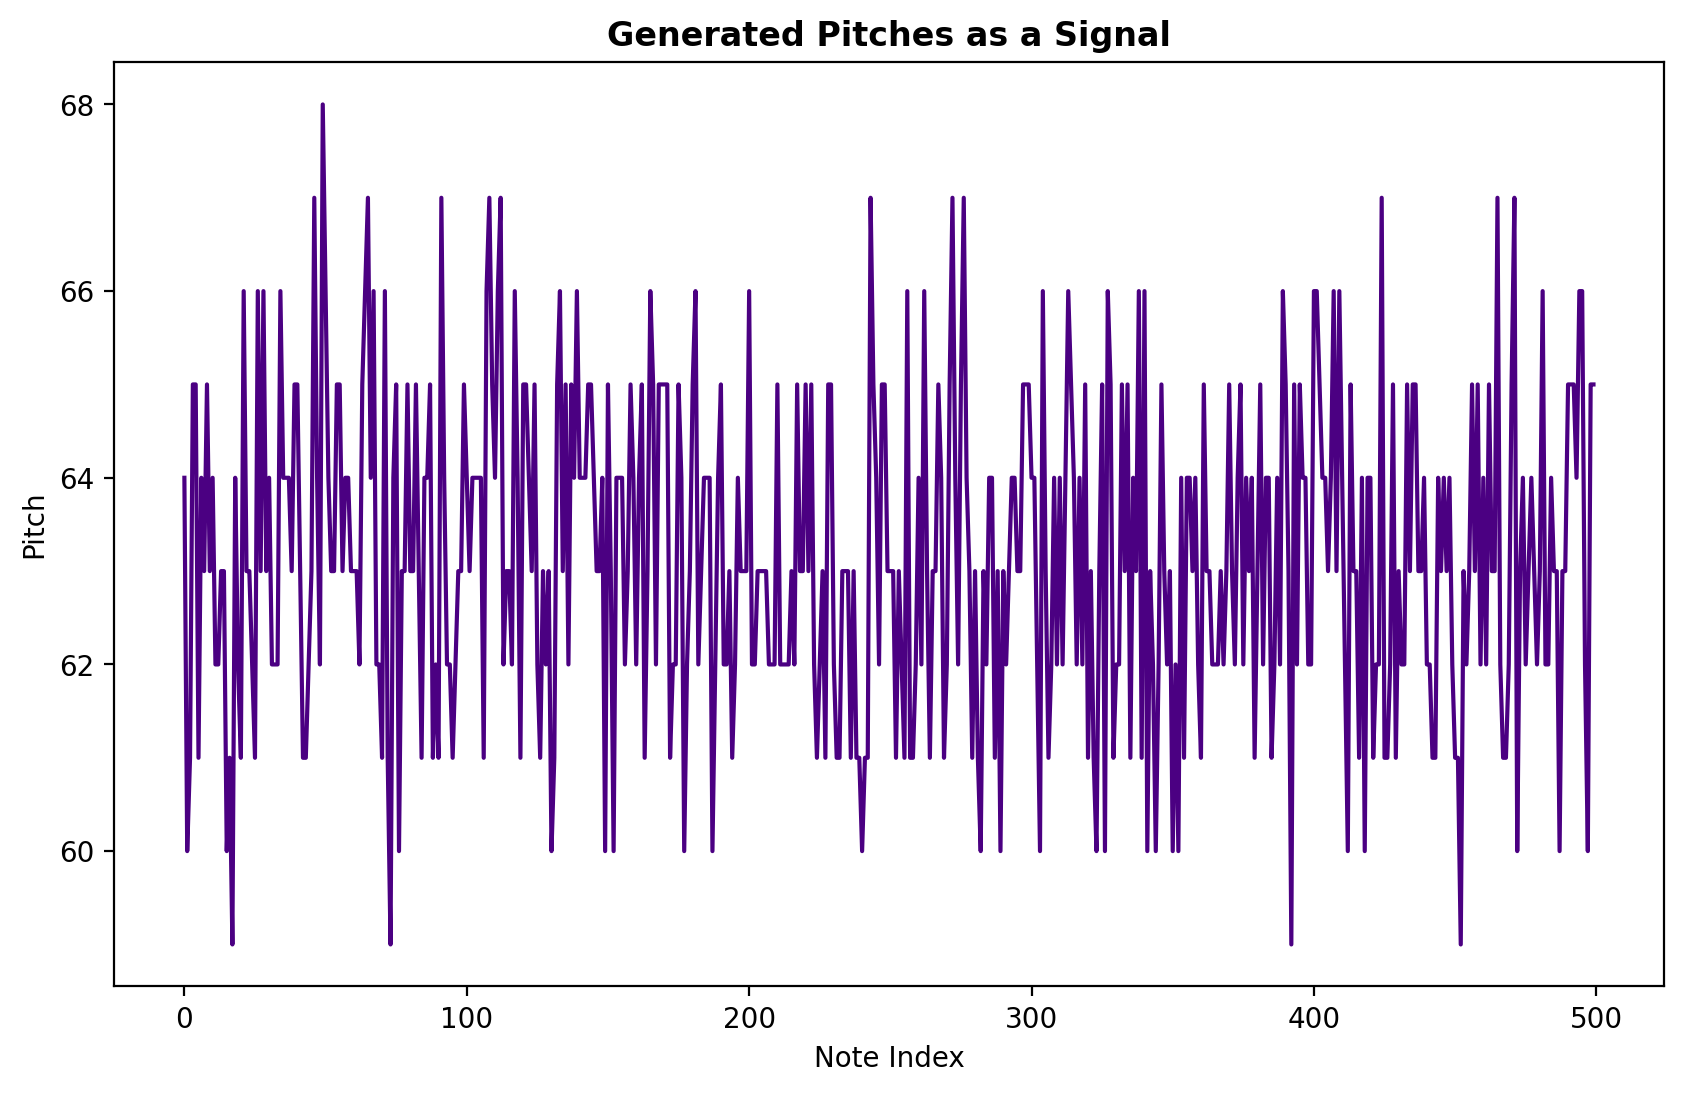

Pitch Quartiles: 25%=62.0, 50%=64.0, 75%=65.0


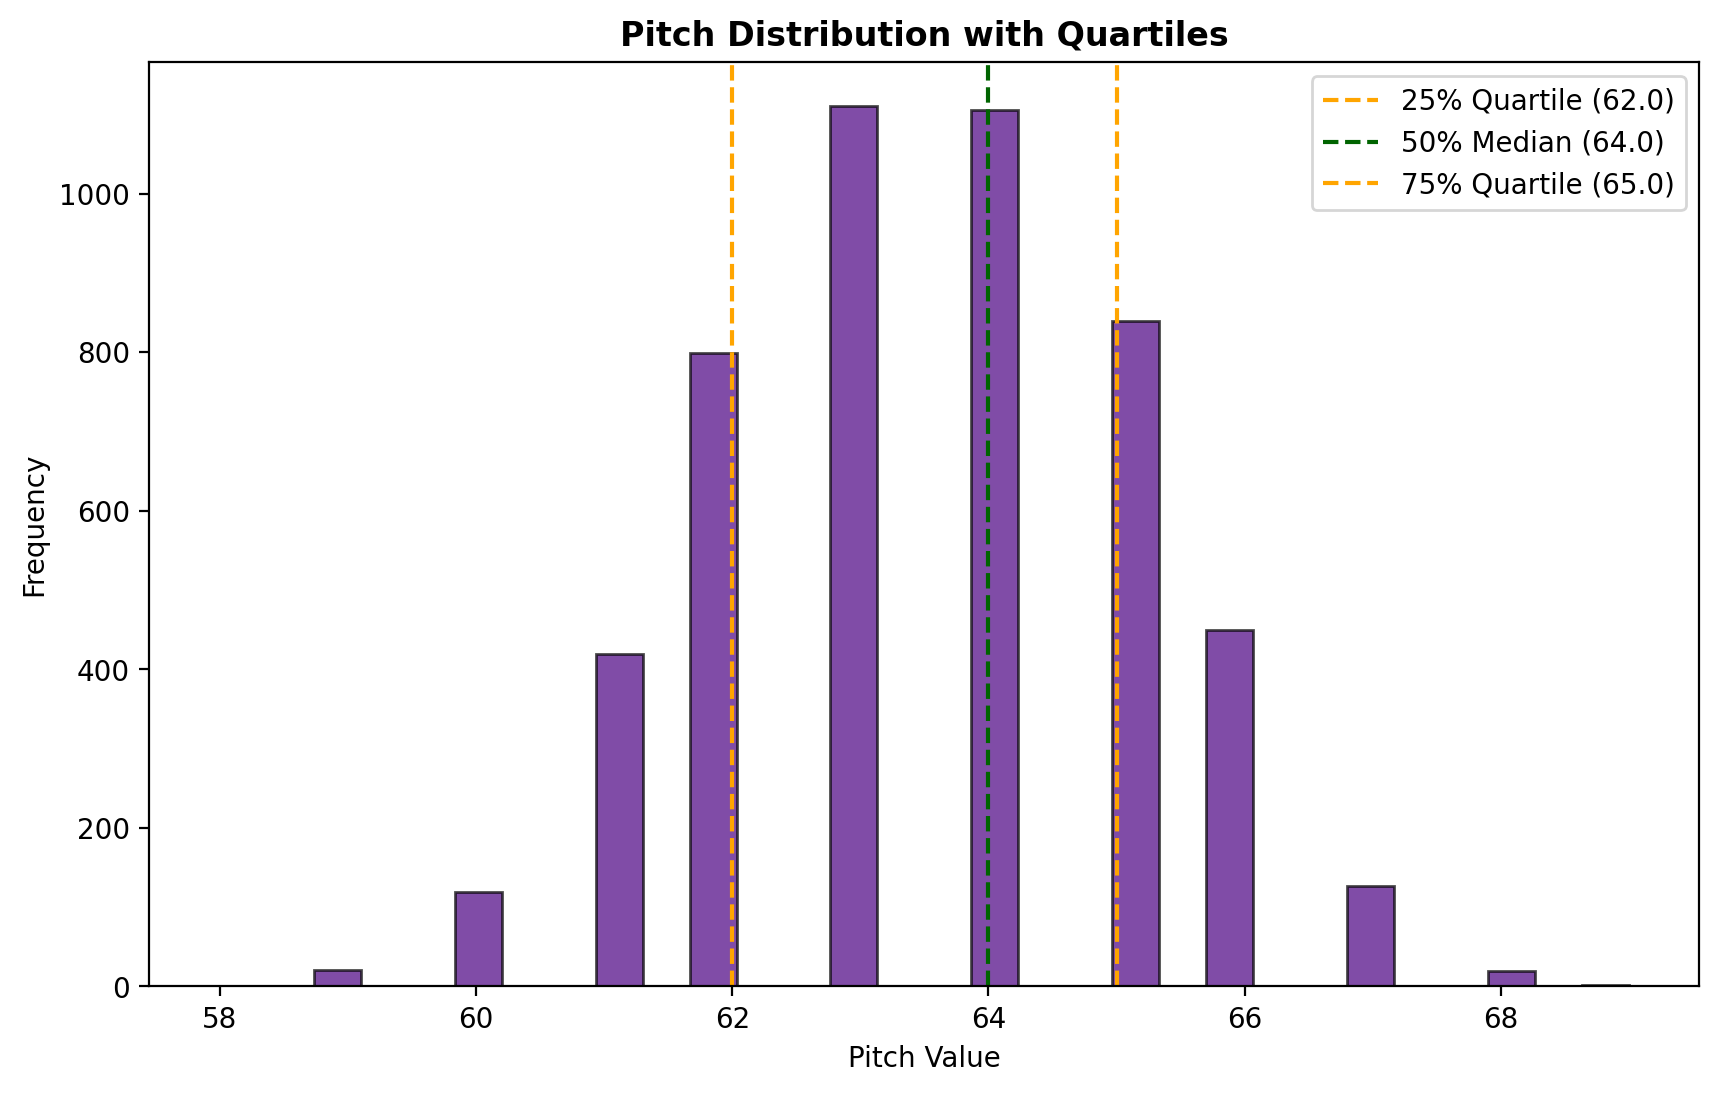

MIDI file saved as /Users/giuliasaresini/Documents/tesi_vs/Bio/musica/generated_music_condizionato_giulia_secondarete.mid


In [18]:
import mido
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def generate_midi(pitch_sequence, velocities_sequence, tempo_category, output_file="generated_music.mid"):
    """
    Function to generate a MIDI file from sequences of pitch, velocity, start time, and duration, considering tempo.
    
    :param pitch_sequence: Generated pitch sequence (values between 0 and 1)
    :param velocities_sequence: Sequence of note velocities
    :param tempo_category: Tempo category ('slow', 'moderate', 'fast')
    :param output_file: Output MIDI file name
    """
    mid = mido.MidiFile()
    track = mido.MidiTrack()
    mid.tracks.append(track)
    
    # Set tempo based on category
    if tempo_category == 'slow':
        bpm = 42
    elif tempo_category == 'moderate':
        bpm = 64
    else:  # fast
        bpm = 127
    tempo_value = int(60_000_000 / bpm)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo_value))  # Set the tempo
    
    # Set the time signature
    track.append(mido.MetaMessage('time_signature', numerator=4, denominator=4))  # 4/4 time (modifiable)

    prev_start = 0  # Initial start time for the sequence
    
    # Iterate over pitch, velocity sequences
    for pitch, velocities in zip(pitch_sequence, velocities_sequence):
        # Calculate the start time in ticks
        start_ticks = int(prev_start + 0.5) * 480  # 480 is the MIDI resolution
        # Calculate the end time in ticks
        end_ticks = int(start_ticks + (0.5 * 480))  # Duration in ticks

        velocity = velocities  # Note velocity (loudness)

        if not (0 <= int(pitch) <= 127):
            raise ValueError(f"Invalid pitch value: {pitch}. It must be between 0 and 127.")
        
        if not (0 <= velocity <= 127):
            raise ValueError(f"Invalid velocity value: {velocity}. It must be between 0 and 127.")

        # Add the "note on" (start) message
        track.append(mido.Message('note_on', note=int(pitch), velocity=velocity, time=prev_start))
        
        # Add the "note off" (end) message
        track.append(mido.Message('note_off', note=int(pitch), velocity=velocity, time=end_ticks - start_ticks ))
        
        # Update prev_start for the next iteration
        prev_start = start_ticks

    # Save the MIDI file
    mid.save(output_file)
    print(f"MIDI file saved as {output_file}")


# Function to generate and save the MIDI file using the GAN model
def generate_midi_from_gan(generator, noise_dim, conditions, output_file="generated_music.mid"):
    """
    Function to generate a MIDI file using the GAN generator conditioned by 'tempo_category' and 'key'.
    
    :param generator: GAN generative model
    :param noise_dim: Dimension of the noise for the generator
    :param conditions: Input conditions (key, tempo_category)
    :param output_file: Output MIDI file name
    """
    noise = tf.random.normal([1, noise_dim])  # Generate random noise
    conditions = np.expand_dims(conditions, axis=0)  # Add a dimension to the conditions array to shape it as (1, 19)

    # Convert the conditions into a tensor
    conditions_tensor = tf.convert_to_tensor(conditions, dtype=tf.float32)  # Make sure it's a float32 tensor

    # Pass the noise and conditions (both tensors) to the generator
    generated_pitches, generated_velocities = generator([noise, conditions_tensor], training=False)

    # Denormalize the pitches to convert them into the MIDI range (0-127)
    generated_velocities = generated_velocities[0] * 127
    denormalized_pitch = generated_pitches[0] * 127
    valid_midi_pitches = np.clip(np.round(denormalized_pitch), 0, 127).astype(int)
    generated_velocities = np.clip(np.round(generated_velocities), 0, 127).astype(int)

    # Visualize the pitches as a signal (time series)
    plt.figure(figsize=(10, 6))
    plt.plot(valid_midi_pitches[:500], linestyle='-', color='#4B0082')  # Line color changed to #4B0082
    plt.title('Generated Pitches as a Signal', fontweight='bold')
    plt.xlabel('Note Index')
    plt.ylabel('Pitch')
    plt.grid(False)
    plt.show()

    # Calculate and plot the pitch distribution (quartiles)
    pitch_quartiles = np.percentile(valid_midi_pitches, [25, 50, 75])
    print(f"Pitch Quartiles: 25%={pitch_quartiles[0]}, 50%={pitch_quartiles[1]}, 75%={pitch_quartiles[2]}")

    plt.figure(figsize=(10, 6))
    plt.hist(valid_midi_pitches, bins=30, color='#4B0082', edgecolor='black', alpha=0.7)
    plt.axvline(pitch_quartiles[0], color='orange', linestyle='--', label=f"25% Quartile ({pitch_quartiles[0]})")
    plt.axvline(pitch_quartiles[1], color='darkgreen', linestyle='--', label=f"50% Median ({pitch_quartiles[1]})")
    plt.axvline(pitch_quartiles[2], color='orange', linestyle='--', label=f"75% Quartile ({pitch_quartiles[2]})")
    plt.title("Pitch Distribution with Quartiles", fontweight='bold')
    plt.xlabel("Pitch Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # Generate the MIDI file
    generate_midi(valid_midi_pitches, generated_velocities, 'moderate', output_file)


# Call the function to generate the MIDI file
generate_midi_from_gan(generator, noise_dim=5011, conditions=[0, 1], output_file="/Users/giuliasaresini/Documents/tesi_vs/Bio/musica/generated_music_condizionato_giulia_secondarete.mid")


# **WORD2VEC + MUSIC GENERATION**

In [19]:
# load the model
model = api.load('word2vec-google-news-300')
# load 'en_core_web_sm' with spacy to tokenzie for every word and to reduce each token to its base form
nlp = spacy.load("en_core_web_lg") 

# Vector for key and tempo used for classifying
tempo_vectors = {
        "fast": model["fast"],
        "moderate": model["moderate"],
        "slow": model["slow"]
    }
key_vectors = {
        "major": model["major"],
        "minor": model["minor"]
    }

def get_textvector(text):
    word_vectors = []
    # Tokenize the text with spacy 
    doc = nlp(text) 
    # for each word in the text: add wordvector if word is in the model
    for token in doc: 
        if token.text.lower() in model.key_to_index:
            word_vectors.append(model[token.text.lower()])
    # vector of zeroes if there are no known words in the text            
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    # calculates vector of the text as mean of the wordvectors in the text
    textvector = np.mean(word_vectors, axis=0)
    return textvector

def get_key_and_tempo(text):
    # Get the vector of the text to compare to the key and tempo vectors
    textvector = get_textvector(text)
    # Calculate similarity between the text and the different tempos
    tempo_similarities = {}
    for key, value in tempo_vectors.items():
        tempo_similarities[key] = np.dot(textvector, value) / (np.linalg.norm(textvector) * np.linalg.norm(value))
    # Calculate similarity between the text and major/minor
    key_similarities = {}
    for key, value in key_vectors.items():
        key_similarities[key] = np.dot(textvector, value) / (np.linalg.norm(textvector) * np.linalg.norm(value))
    #select right key and tempo
    tempo = max(tempo_similarities, key=tempo_similarities.get)
    key = max(key_similarities, key=key_similarities.get)


    print(f"Tempo: {tempo}, Tonart: {key}")
    return key, tempo # should feed this in the cGAN

In [20]:
# Text to analyze
testo = "This music feels very fast and energetic, probably in a major key."

key, tempo = get_key_and_tempo(testo)


Tempo: fast, Tonart: major


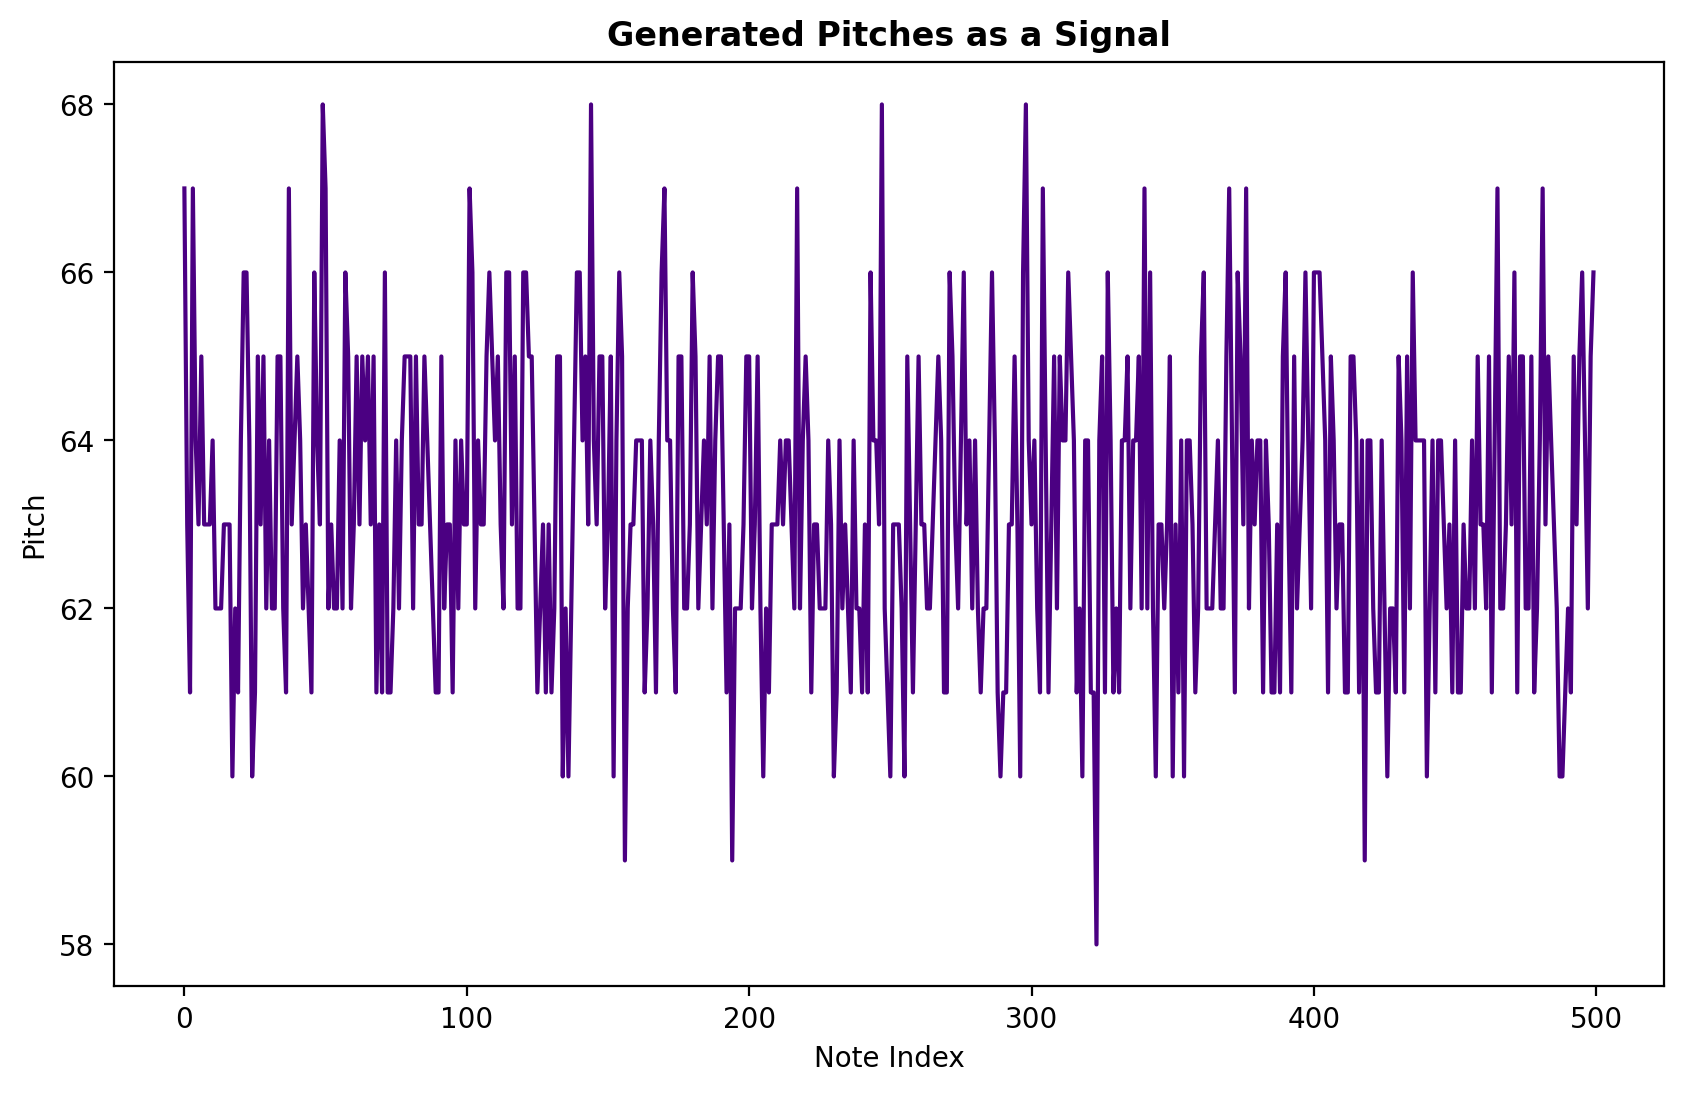

Pitch Quartiles: 25%=62.0, 50%=64.0, 75%=65.0


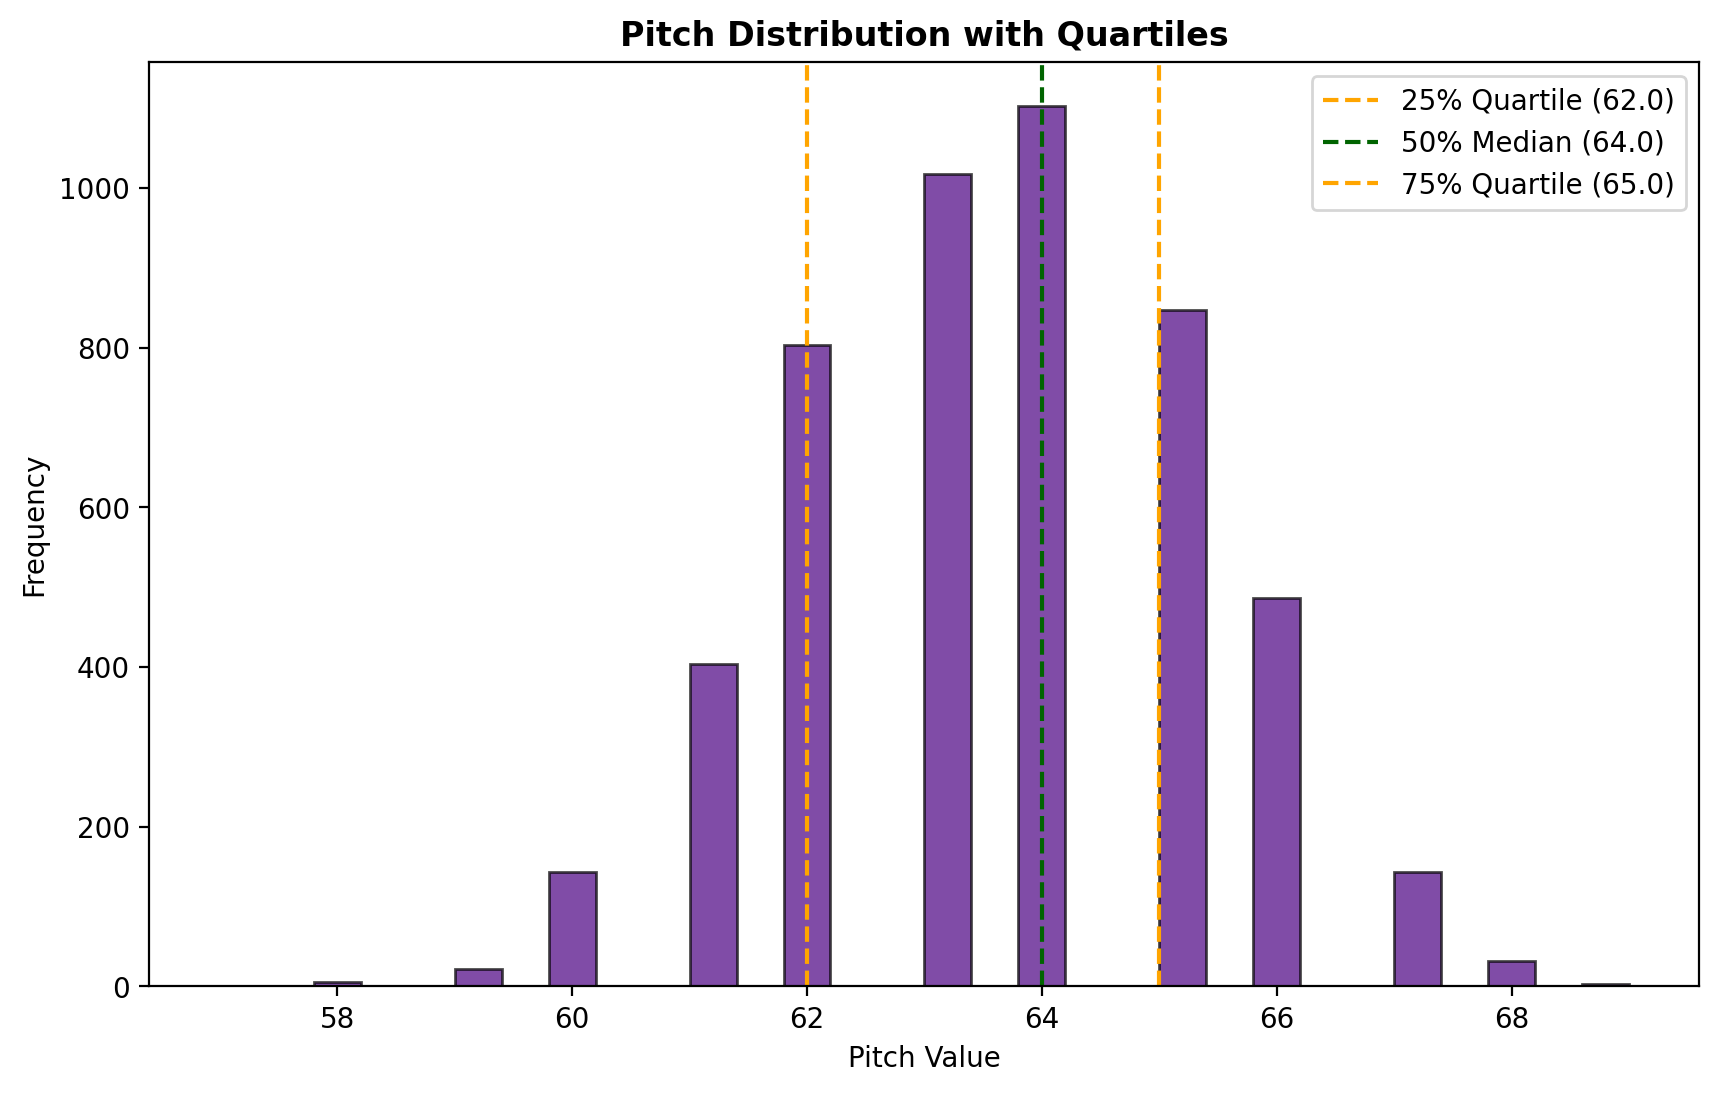

fast
MIDI file saved as /Users/giuliasaresini/Documents/tesi_vs/Bio/musica/generated_music_1.mid


In [21]:
def generate_midi(pitch_sequence, velocities_sequence, tempo_category, output_file="generated_music.mid"):
    """
    Function to generate a MIDI file from sequences of pitch, velocity, start time, and duration, considering tempo.
    
    :param pitch_sequence: Generated pitch sequence (values between 0 and 1)
    :param velocities_sequence: Sequence of note velocities
    :param tempo_category: Tempo category ('slow', 'moderate', 'fast')
    :param output_file: Output MIDI file name
    """
    mid = mido.MidiFile()
    track = mido.MidiTrack()
    mid.tracks.append(track)

    print(tempo_category)
    
    # Set tempo based on category
    if tempo_category == 'slow':
        bpm = 42
    elif tempo_category == 'moderate':
        bpm = 64
    else:  # fast
        bpm = 127
    tempo_value = int(60_000_000 / bpm)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo_value))  # Set the tempo
    
    # Set the time signature
    track.append(mido.MetaMessage('time_signature', numerator=4, denominator=4))  # 4/4 time (modifiable)

    prev_start = 0  # Initial start time for the sequence
    
    # Iterate over pitch, velocity sequences
    for pitch, velocities in zip(pitch_sequence, velocities_sequence):
        # Calculate the start time in ticks
        start_ticks = int(prev_start + 0.5) * 480  # 480 is the MIDI resolution
        # Calculate the end time in ticks
        end_ticks = int(start_ticks + (0.5 * 480))  # Duration in ticks

        velocity = velocities  # Note velocity (loudness)

        if not (0 <= int(pitch) <= 127):
            raise ValueError(f"Invalid pitch value: {pitch}. It must be between 0 and 127.")
        
        if not (0 <= velocity <= 127):
            raise ValueError(f"Invalid velocity value: {velocity}. It must be between 0 and 127.")

        # Add the "note on" (start) message
        track.append(mido.Message('note_on', note=int(pitch), velocity=velocity, time=prev_start))
        
        # Add the "note off" (end) message
        track.append(mido.Message('note_off', note=int(pitch), velocity=velocity, time=end_ticks - start_ticks ))
        
        # Update prev_start for the next iteration
        prev_start = start_ticks

    # Save the MIDI file
    mid.save(output_file)
    print(f"MIDI file saved as {output_file}")


# Function to generate and save the MIDI file using the GAN model
def generate_midi_from_gan(generator, noise_dim, conditions, tempo, output_file="generated_music.mid"):
    """
    Function to generate a MIDI file using the GAN generator conditioned by 'tempo_category' and 'key'.
    
    :param generator: GAN generative model
    :param noise_dim: Dimension of the noise for the generator
    :param conditions: Input conditions (key, tempo_category)
    :param output_file: Output MIDI file name
    """
    noise = tf.random.normal([1, noise_dim])  # Generate random noise
    if conditions == 'major':
        conditions = [0, 1]
    elif conditions == 'minor':
        conditions = [1, 0]
    conditions = np.expand_dims(conditions, axis=0)  # Add a dimension to the conditions array to shape it as (1, 19)

    # Convert the conditions into a tensor
    conditions_tensor = tf.convert_to_tensor(conditions, dtype=tf.float32)  # Make sure it's a float32 tensor

    # Pass the noise and conditions (both tensors) to the generator
    generated_pitches, generated_velocities = generator([noise, conditions_tensor], training=False)

    # Denormalize the pitches to convert them into the MIDI range (0-127)
    generated_velocities = generated_velocities[0] * 127
    denormalized_pitch = generated_pitches[0] * 127
    valid_midi_pitches = np.clip(np.round(denormalized_pitch), 0, 127).astype(int)
    generated_velocities = np.clip(np.round(generated_velocities), 0, 127).astype(int)

    # Visualize the pitches as a signal (time series)
    plt.figure(figsize=(10, 6))
    plt.plot(valid_midi_pitches[:500], linestyle='-', color='#4B0082')  # Line color changed to #4B0082
    plt.title('Generated Pitches as a Signal', fontweight='bold')
    plt.xlabel('Note Index')
    plt.ylabel('Pitch')
    plt.grid(False)
    plt.show()

    # Calculate and plot the pitch distribution (quartiles)
    pitch_quartiles = np.percentile(valid_midi_pitches, [25, 50, 75])
    print(f"Pitch Quartiles: 25%={pitch_quartiles[0]}, 50%={pitch_quartiles[1]}, 75%={pitch_quartiles[2]}")

    plt.figure(figsize=(10, 6))
    plt.hist(valid_midi_pitches, bins=30, color='#4B0082', edgecolor='black', alpha=0.7)
    plt.axvline(pitch_quartiles[0], color='orange', linestyle='--', label=f"25% Quartile ({pitch_quartiles[0]})")
    plt.axvline(pitch_quartiles[1], color='darkgreen', linestyle='--', label=f"50% Median ({pitch_quartiles[1]})")
    plt.axvline(pitch_quartiles[2], color='orange', linestyle='--', label=f"75% Quartile ({pitch_quartiles[2]})")
    plt.title("Pitch Distribution with Quartiles", fontweight='bold')
    plt.xlabel("Pitch Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # Generate the MIDI file
    generate_midi(valid_midi_pitches, generated_velocities, tempo, output_file)


# Call the function to generate the MIDI file
generate_midi_from_gan(generator, noise_dim=5011, conditions=key, tempo = tempo, output_file="/Users/giuliasaresini/Documents/tesi_vs/Bio/musica/generated_music_1.mid")

## **SIGNAL OF REAL MUSIC TRACK**

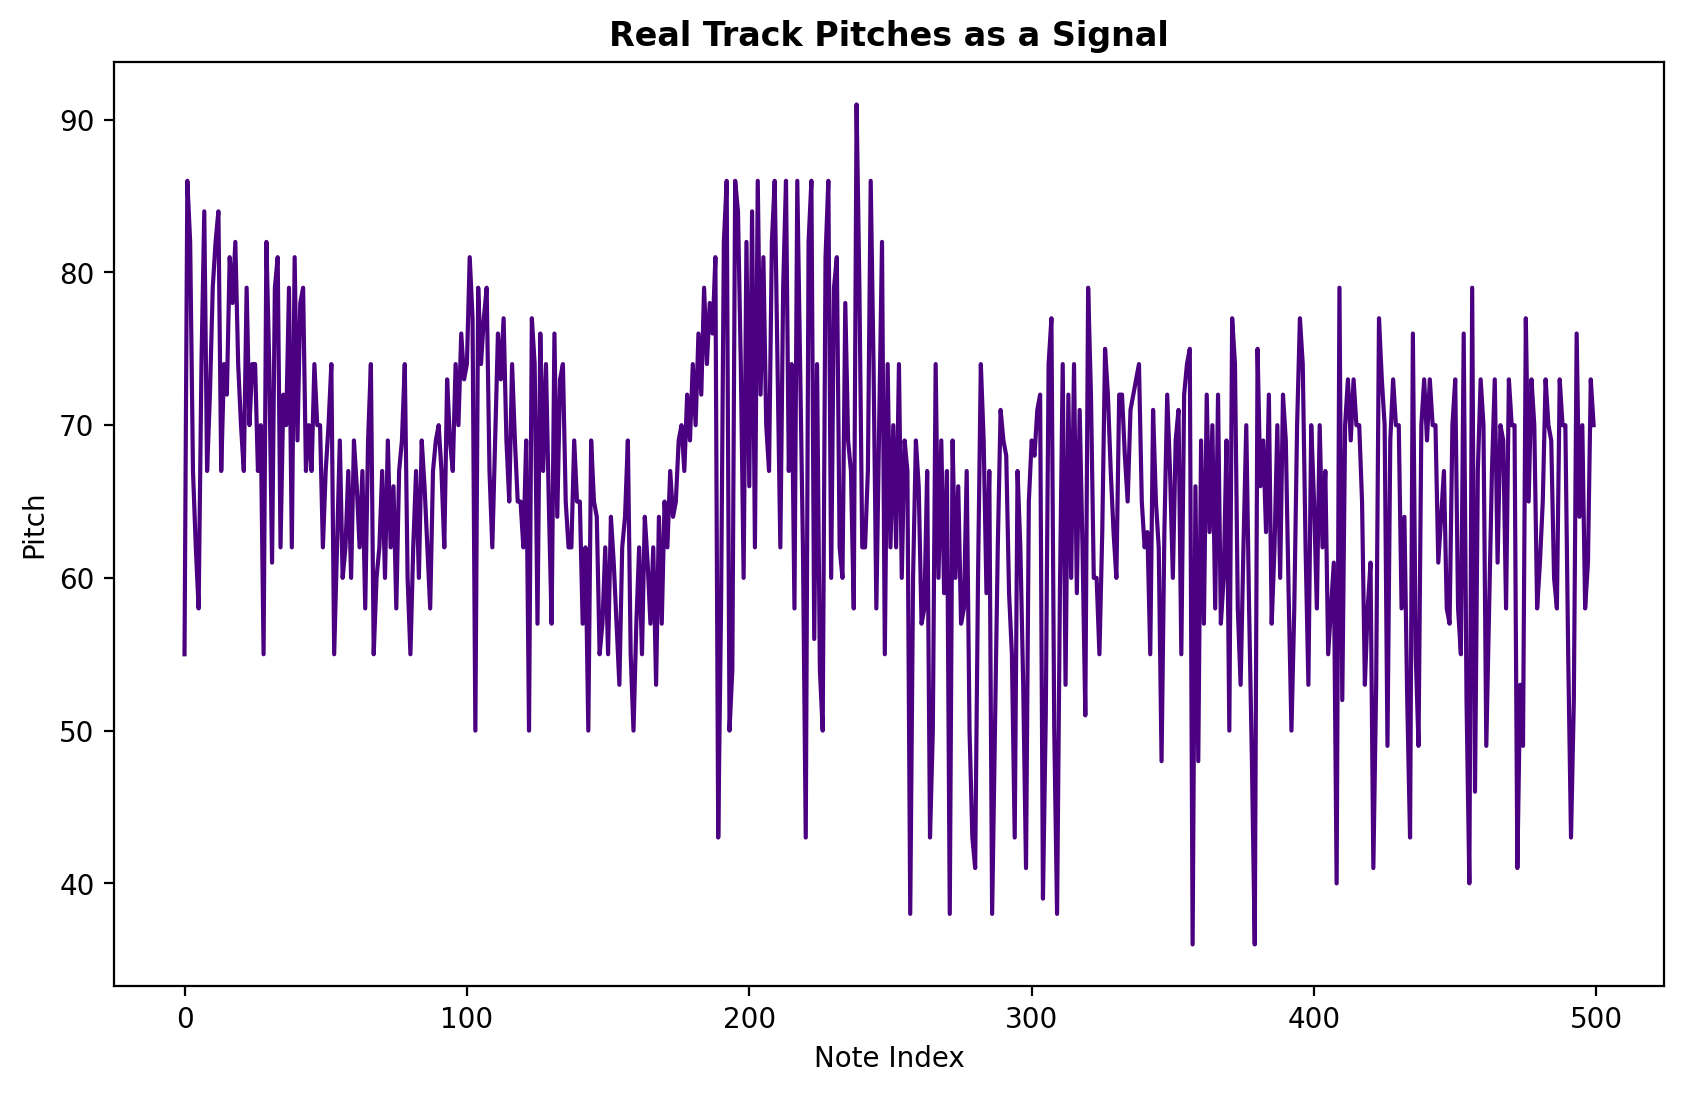

In [25]:
dataset_path = '/Users/giuliasaresini/Documents/tesi_vs/Bio/dataset/dataset_padded_cGAN.csv'
df = pd.read_csv(dataset_path)

# Apply ast.literal_eval() to all rows of the specified columns
columns_to_convert = ['pitches', 'velocity', 'starts', 'ends']

for col in columns_to_convert:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


plt.figure(figsize=(10, 6))
plt.plot(df['pitches'][29][:500], linestyle='-', color='#4B0082')  # Line color changed to #4B0082
plt.title('Real Track Pitches as a Signal', fontweight='bold')
plt.xlabel('Note Index')
plt.ylabel('Pitch')
plt.grid(False)
plt.show()

## **KEY CONDITIONS CHECK**

In [30]:
# Function to fix the key notation
def fix_key_notation(key_name):
    """Fixes the key notation from '- minor' or '- major' to ' minor' or ' major'."""
    if '- minor' in key_name:
        key_name = key_name.replace('- minor', ' minor')
    if '- major' in key_name:
        key_name = key_name.replace('- major', ' major')
    return key_name

# Function to estimate the key
def estimate_key(midi_data):
    """
    Estimates the musical key of a MIDI object using music21.
    Returns:
        1 for major key
        0 for minor key
       -1 if the key is not recognized or an error occurs
    """
    try:
        # Create a temporary file to analyze the MIDI with music21
        with tempfile.NamedTemporaryFile(suffix='.mid', delete=False) as temp_file:
            temp_file_name = temp_file.name
            midi_data.write(temp_file_name)

            # Analyze the key using music21
            score = converter.parse(temp_file_name)
            music_analysis = score.analyze('key')
            os.remove(temp_file_name)

            # Mapping of major and minor keys
            key_mapping = {
                'C major': 1, 'C# major': 1, 'D major': 1, 'D# major': 1, 'E major': 1, 'F major': 1,
                'F# major': 1, 'G major': 1, 'G# major': 1, 'A major': 1, 'A# major': 1, 'B major': 1,
                'c minor': 0, 'c# minor': 0, 'd minor': 0, 'd# minor': 0, 'e minor': 0, 'f minor': 0,
                'f# minor': 0, 'g minor': 0, 'g# minor': 0, 'a minor': 0, 'a# minor': 0, 'b minor': 0
            }

            # Fix the key notation
            key_name = fix_key_notation(str(music_analysis).strip())

            # Return 1 for major, 0 for minor, and -1 if unrecognized
            return key_mapping.get(key_name, -1)
    except Exception as e:
        print(f"Error during key analysis: {e}")
        return -1  # Return -1 in case of an error

# Function to generate a MIDI file
def generate_midi(pitch_sequence, velocities_sequence, tempo_category):
    """
    Generates a MIDI file from pitch and velocity sequences, without saving it to disk.
    Returns a pretty_midi.PrettyMIDI object.
    """
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano

    # Create notes and add them to the instrument
    for pitch, velocity in zip(pitch_sequence, velocities_sequence):
        note_start = np.random.uniform(0, 1)  # Randomized start time
        note_duration = 0.5  # Fixed duration (modifiable)
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(pitch),
            start=note_start,
            end=note_start + note_duration
        )
        instrument.notes.append(note)

    # Add the instrument to the MIDI file
    midi.instruments.append(instrument)
    return midi

# Function to generate a MIDI file using GAN
def generate_midi_from_gan(generator, noise_dim, conditions, tempo_category):
    """
    Generates a MIDI file using a GAN generator, given conditions for key and tempo.
    Returns a pretty_midi.PrettyMIDI object.
    """
    noise = tf.random.normal([1, noise_dim])  # Generate random noise
    conditions = [0, 1]  # Fixed to "major"
    conditions = np.expand_dims(conditions, axis=0)  # Add a dimension to the conditions array

    # Convert the conditions into a tensor
    conditions_tensor = tf.convert_to_tensor(conditions, dtype=tf.float32)

    # Pass the noise and conditions to the generator
    generated_pitches, generated_velocities = generator([noise, conditions_tensor], training=False)

    # Denormalize the pitches to convert them into the MIDI range (0-127)
    generated_velocities = np.clip(np.round(generated_velocities[0] * 127), 0, 127).astype(int)
    denormalized_pitch = np.clip(np.round(generated_pitches[0] * 127), 0, 127).astype(int)

    # Generate the MIDI file
    return generate_midi(denormalized_pitch, generated_velocities, tempo_category)

# Generate 100 MIDI files with key condition set to "major"
major_count = 0
minor_count = 0

for i in range(100):
    # Generate a random tempo category
    tempo_category = np.random.choice(['slow', 'moderate', 'fast'])

    # Generate the MIDI file
    midi_data = generate_midi_from_gan(generator, noise_dim=5011, conditions='major', tempo_category=tempo_category)

    # Analyze the key of the generated MIDI file
    key_numeric = estimate_key(midi_data)

    if key_numeric == 1:
        major_count += 1
    elif key_numeric == 0:
        minor_count += 1

# Print the results
print(f"Generated files with condition 'major':")
print(f"Major key count: {major_count}")
print(f"Minor key count: {minor_count}")


Generated files with condition 'major':
Major key count: 52
Minor key count: 48


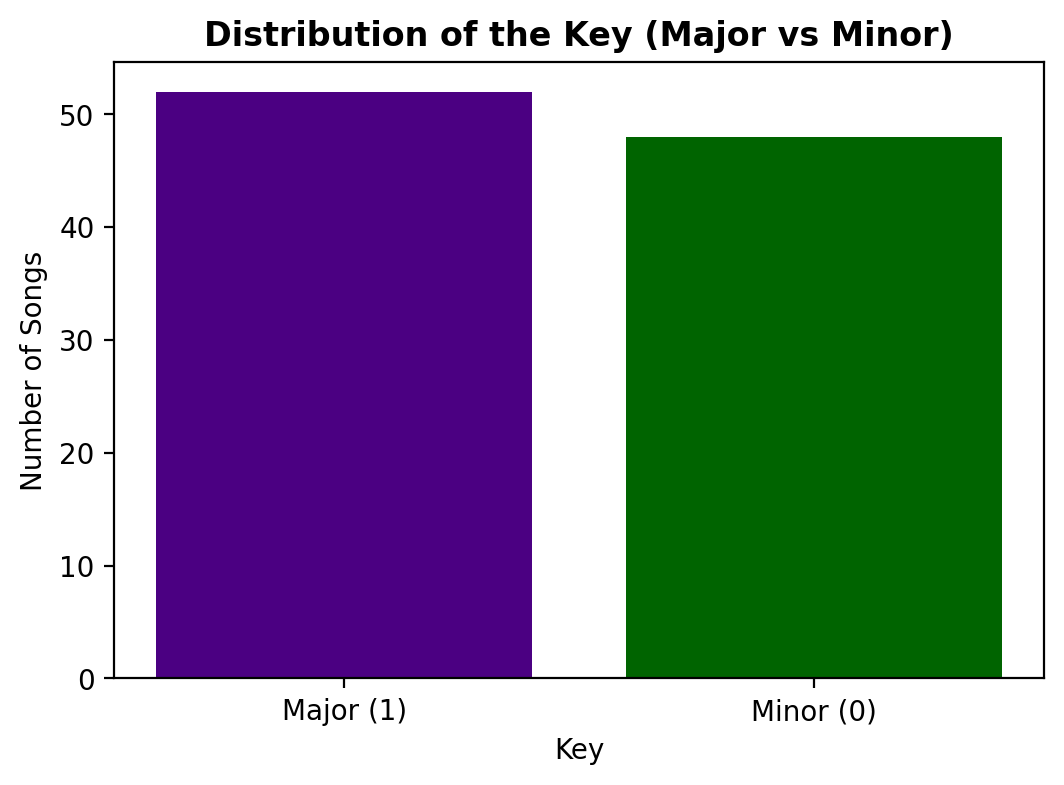

In [31]:
# Plot the distribution of keys
plt.figure(figsize=(6, 4))
plt.bar(['Major (1)', 'Minor (0)'], [major_count, minor_count], color=['#4B0082', 'darkgreen'])
plt.title('Distribution of the Key (Major vs Minor)', fontweight='bold')
plt.xlabel('Key')
plt.ylabel('Number of Songs')
plt.show()

In [32]:
# Function to fix the key notation
def fix_key_notation(key_name):
    """Fixes the key notation from '- minor' or '- major' to ' minor' or ' major'."""
    if '- minor' in key_name:
        key_name = key_name.replace('- minor', ' minor')
    if '- major' in key_name:
        key_name = key_name.replace('- major', ' major')
    return key_name

# Function to estimate the key
def estimate_key(midi_data):
    """
    Estimates the musical key of a MIDI object using music21.
    Returns:
        1 for major key
        0 for minor key
       -1 if the key is not recognized or an error occurs
    """
    try:
        # Create a temporary file to analyze the MIDI with music21
        with tempfile.NamedTemporaryFile(suffix='.mid', delete=False) as temp_file:
            temp_file_name = temp_file.name
            midi_data.write(temp_file_name)

            # Analyze the key using music21
            score = converter.parse(temp_file_name)
            music_analysis = score.analyze('key')
            os.remove(temp_file_name)

            # Mapping of major and minor keys
            key_mapping = {
                'C major': 1, 'C# major': 1, 'D major': 1, 'D# major': 1, 'E major': 1, 'F major': 1,
                'F# major': 1, 'G major': 1, 'G# major': 1, 'A major': 1, 'A# major': 1, 'B major': 1,
                'c minor': 0, 'c# minor': 0, 'd minor': 0, 'd# minor': 0, 'e minor': 0, 'f minor': 0,
                'f# minor': 0, 'g minor': 0, 'g# minor': 0, 'a minor': 0, 'a# minor': 0, 'b minor': 0
            }

            # Fix the key notation
            key_name = fix_key_notation(str(music_analysis).strip())

            # Return 1 for major, 0 for minor, and -1 if unrecognized
            return key_mapping.get(key_name, -1)
    except Exception as e:
        print(f"Error during key analysis: {e}")
        return -1  # Return -1 in case of an error

# Function to generate a MIDI file
def generate_midi(pitch_sequence, velocities_sequence, tempo_category):
    """
    Generates a MIDI file from pitch and velocity sequences, without saving it to disk.
    Returns a pretty_midi.PrettyMIDI object.
    """
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano

    # Create notes and add them to the instrument
    for pitch, velocity in zip(pitch_sequence, velocities_sequence):
        note_start = np.random.uniform(0, 1)  # Randomized start time
        note_duration = 0.5  # Fixed duration (modifiable)
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(pitch),
            start=note_start,
            end=note_start + note_duration
        )
        instrument.notes.append(note)

    # Add the instrument to the MIDI file
    midi.instruments.append(instrument)
    return midi

# Function to generate a MIDI file using GAN
def generate_midi_from_gan(generator, noise_dim, conditions, tempo_category):
    """
    Generates a MIDI file using a GAN generator, given conditions for key and tempo.
    Returns a pretty_midi.PrettyMIDI object.
    """
    noise = tf.random.normal([1, noise_dim])  # Generate random noise
    conditions = [0, 1]  # Fixed to "major"
    conditions = np.expand_dims(conditions, axis=0)  # Add a dimension to the conditions array

    # Convert the conditions into a tensor
    conditions_tensor = tf.convert_to_tensor(conditions, dtype=tf.float32)

    # Pass the noise and conditions to the generator
    generated_pitches, generated_velocities = generator([noise, conditions_tensor], training=False)

    # Denormalize the pitches to convert them into the MIDI range (0-127)
    generated_velocities = np.clip(np.round(generated_velocities[0] * 127), 0, 127).astype(int)
    denormalized_pitch = np.clip(np.round(generated_pitches[0] * 127), 0, 127).astype(int)

    # Generate the MIDI file
    return generate_midi(denormalized_pitch, generated_velocities, tempo_category)

# Generate 100 MIDI files with key condition set to "major"
major_count = 0
minor_count = 0

for i in range(100):
    # Generate a random tempo category
    tempo_category = np.random.choice(['slow', 'moderate', 'fast'])

    # Generate the MIDI file
    midi_data = generate_midi_from_gan(generator, noise_dim=5011, conditions='minor', tempo_category=tempo_category)

    # Analyze the key of the generated MIDI file
    key_numeric = estimate_key(midi_data)

    if key_numeric == 1:
        major_count += 1
    elif key_numeric == 0:
        minor_count += 1

# Print the results
print(f"Generated files with condition 'major':")
print(f"Major key count: {major_count}")
print(f"Minor key count: {minor_count}")


Generated files with condition 'major':
Major key count: 56
Minor key count: 44


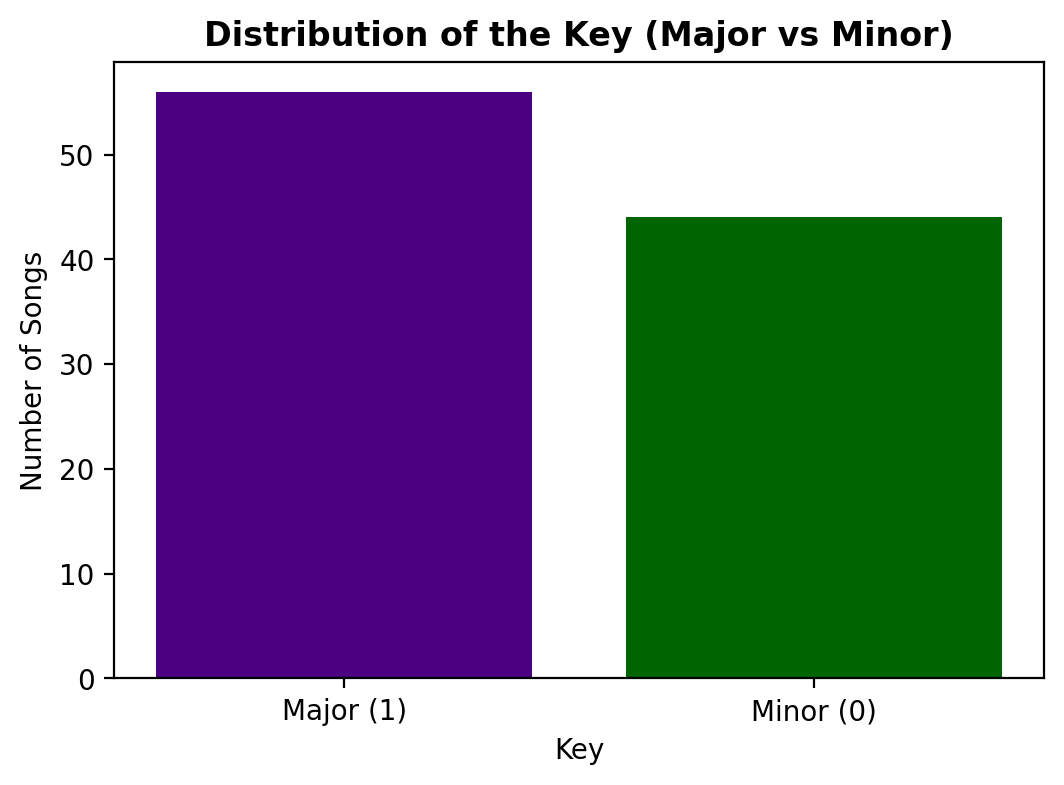

In [33]:
# Plot the distribution of keys
plt.figure(figsize=(6, 4))
plt.bar(['Major (1)', 'Minor (0)'], [major_count, minor_count], color=['#4B0082', 'darkgreen'])
plt.title('Distribution of the Key (Major vs Minor)', fontweight='bold')
plt.xlabel('Key')
plt.ylabel('Number of Songs')
plt.show()